# ML Final Project


### Name #1, Shruti Kotha, Mia Tey, and Shruti Patel

In [33]:
#add imports
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns



ModuleNotFoundError: No module named 'seaborn'

## Final Project Objective: 
We can use the features (age, breed, color, animal, sex upon outcome, outcome subtype,
name) to predict outcome (Foster, Adoption, Transfer, Euthanize)

### Part 1. Data Preperation for Modeling

For this part of the assignment we read in our data and will perform various data prep techniques like data cleaning and feature engineering to prepare our data for modeling.

In [19]:
data = pd.read_csv('animaloutcomes.csv', skipinitialspace = True)
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


#### Data cleaning

View the distribution of "Outcome Type". We want to ensure there is sufficient data for each "Outcome Type" and if there isn't we can drop columns as needed.

In [20]:
outcome_counts = data['Outcome Type'].value_counts()
print(outcome_counts)

Outcome Type
Adoption           73675
Transfer           44935
Return to Owner    24404
Euthanasia          9959
Died                1468
Rto-Adopt           1061
Disposal             758
Missing               84
Relocate              27
Stolen                 5
Name: count, dtype: int64


First, our label column will be "Outcome Type", since that is what we want to predict. 
If there are any records that lack an entry for "Outcome Type" we drop them.

In [21]:
print("Length before droping Outcome Type: ", len(data['Outcome Type']))
data = data.dropna(subset=['Outcome Type'])
print("Length after drop Outcome Type: ", len(data['Outcome Type']))

Length before droping Outcome Type:  156406
Length after drop Outcome Type:  156376


Second, we want to drop "Outcome Subtype". Since most rows have NaN in the "Outcome Subtype" column, it won't be an important column for us to use in our model.

In [22]:
data.drop(columns=['Outcome Subtype'], inplace=True)
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


It looks like there are no missing values for 'Outcome Type' anymore... Great!


Looking at the names column, there are a lot of blank entries for names. For the purposes of testing, we are
going to test with both dropping the names column and keeping it. 
First, let's see how many blank entries there are.
Second, create a temporary dataset that drops records with N/A for name. Later, we will see if accuracy is better or worse with the version that drops null name entries.

In [23]:
total_null =  data["Name"].isnull().sum()
print("Total missing values in 'Name' col before drop: ", total_null)
print("Ratio of total records with N/A for 'Name': ", total_null/len(data["Name"]), "\n")

# Create a temporary dataset that drops records with N/A for name
temp_drop_data = data.dropna(subset=['Name'])
# Verify we dropped the null records
total_null =  temp_drop_data["Name"].isnull().sum()
print("Total missing values in 'Name' col after drop: ", total_null)

Total missing values in 'Name' col before drop:  44971
Ratio of total records with N/A for 'Name':  0.28758249347725995 

Total missing values in 'Name' col after drop:  0


As for the colors, since we plan on using them for our models later, we should simplify the categories, as there are way too many unique categories for testing.
First, there are entries such as 'black/white' and 'white/black' let's combine these into one label.
Second, there are a lot of unique combinations of two colors. For these records whose combination of color makes up <5% of all colors, add these into one column called 'Multicolor' and jointly categorize it with the 'Tricolor' attribute.

In [24]:
# Combine categories such as 'black/white' and 'white/black'
def join_same_color(color):
    color_components = color.split('/')
    color_components.sort()
    return '/'.join(color_components)
data['Color'] = data['Color'].apply(join_same_color)



# Create Multicolor category 
color_counts = data['Color'].value_counts()
color_percent = color_counts / color_counts.sum() * 100
less_than_5_percent = color_percent[color_percent < 1].index
data['Color'] = data['Color'].apply(lambda x: 'Multicolor' if x in less_than_5_percent or x == 'Tricolor' else x)

Create new column for seasons

In [25]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'
    
data['Month'] = pd.to_datetime(data['MonthYear'], format='%b %Y').dt.month
data['Season'] = data['Month'].apply(get_season)
data = data.drop('Month', axis=1)
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Season
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,Spring
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,Brown/White,Summer
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,Other,Unknown,1 year,Raccoon,Multicolor,Summer
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Multicolor,Winter
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,Spring


We'll be categorizing the various breeds in the dataset. https://www.trainpetdog.com/dog-breed-size-chart/

In [133]:

# only keep records that are Dogs
records_to_keep = ['Dog']
dog_data = data[data['Animal Type'].isin(records_to_keep)]

# only keep top 100 most frequent dog breeds in dataset
top_100_breeds = dog_data['Breed'].value_counts().head(100).index
breeds_data = dog_data[dog_data['Breed'].isin(top_100_breeds)]
breeds_data = breeds_data.copy()

# print(top_100_breeds)



# large 70 + lbs avg, small, medium
breed_to_category = {
    'Pit Bull Mix': 'Medium/Large Breeds',
    'Labrador Retriever Mix': 'Medium/Large Breeds',
    'Chihuahua Shorthair Mix': 'Small Breeds',
    'German Shepherd Mix': 'Medium/Large Breeds',
    'Pit Bull': 'Medium/Large Breeds',
    'Australian Cattle Dog Mix': 'Medium/Large Breeds',
    'Chihuahua Shorthair': 'Small Breeds',
    'Labrador Retriever': 'Medium/Large Breeds',
    'German Shepherd': 'Medium/Large Breeds',
    'Dachshund Mix': 'Medium/Small Breeds', 
    'Boxer Mix': 'Medium/Large Breeds',
    'Border Collie Mix': 'Medium/Large Breeds',
    'Miniature Poodle Mix': 'Small Breeds',
    'Siberian Husky Mix': 'Medium Breeds',
    'Australian Shepherd Mix': 'Medium/Large Breeds',
    'Catahoula Mix': 'Medium/Large Breeds',
    'Staffordshire Mix': 'Medium/Large Breeds',
    'Siberian Husky': 'Medium Breeds',
    'Rat Terrier Mix': 'Small Breeds',
    'Great Pyrenees Mix': 'Large Breeds',
    'Yorkshire Terrier Mix': 'Small Breeds',
    'Beagle Mix': 'Medium/Large Breeds',
    'Miniature Schnauzer Mix': 'Medium/Small Breeds',
    'Jack Russell Terrier Mix': 'Medium/Small Breeds',
    'Pointer Mix': 'Large Breeds',
    'Cairn Terrier Mix' : 'Small Breeds',
    'American Bulldog Mix': 'Medium/Large Breeds',                      
    'Chihuahua Longhair Mix': 'Small Breeds',   
    'Anatol Shepherd Mix': 'Medium/Large Breeds',
    'Rottweiler Mix': 'Medium/Large Breeds',
    'Australian Cattle Dog': 'Medium Breeds',
    'Black Mouth Cur Mix': 'Medium/Large Breeds',
    'Plott Hound Mix': 'Medium/Large Breeds',
    'Labrador Retriever/Pit Bull': 'Medium/Large Breeds',
    'Australian Kelpie Mix': 'Medium Breeds',
    'Shih Tzu Mix': 'Small Breeds',
    'Chihuahua Shorthair/Dachshund': 'Small Breeds',
    'Great Pyrenees': 'Large Breeds',
    'American Pit Bull Terrier Mix': 'Medium/Large Breeds',
    'German Shepherd/Labrador Retriever': 'Large Breeds',
    'Dachshund/Chihuahua Shorthair': 'Small Breeds',
    'Labrador Retriever/German Shepherd': 'Large Breeds',
    'American Staffordshire Terrier Mix': 'Medium/Large Breeds',
    'Rottweiler': 'Large Breeds',
    'Boxer': 'Medium/Large Breeds',
    'Shih Tzu': 'Small Breeds',
    'Pit Bull/Labrador Retriever': 'Medium/Large Breeds',
    'Dachshund': 'Small Breeds',
    'Golden Retriever Mix': 'Large Breeds',
    'Maltese Mix': 'Small Breeds',
    'Border Terrier Mix': 'Small Breeds',
    'Miniature Pinscher Mix': 'Small Breeds',
    'Yorkshire Terrier': 'Small Breeds',
    'Blue Lacy Mix': 'Medium/Large Breeds',
    'Doberman Pinsch Mix': 'Medium/Large Breeds',
    'Miniature Poodle': 'Small Breeds',
    'Chow Chow Mix': 'Medium/Large Breeds',
    'American Pit Bull Terrier': 'Medium/Large Breeds',
    'Cairn Terrier': 'Small Breeds',
    'Border Collie': 'Medium/Large Breeds',
    'Queensland Heeler Mix': 'Medium Breeds',
    'Doberman Pinsch': 'Medium/Large Breeds',
    'Basset Hound Mix': 'Medium/Large Breeds',
    'Labrador Retriever/Border Collie': 'Large Breeds',
    'Alaskan Husky Mix': 'Medium/Large Breeds',
    'Pug Mix': 'Small Breeds',
    'Beagle': 'Small Breeds',
    'Pomeranian Mix': 'Small Breeds',
    'Mastiff Mix': 'Large Breeds',
    'Cocker Spaniel Mix': 'Small Breeds',
    'Cardigan Welsh Corgi Mix': 'Medium Breeds',
    'Miniature Schnauzer': 'Small Breeds',
    'Lhasa Apso Mix': 'Small Breeds',
    'Chinese Sharpei Mix': 'Medium/Large Breeds',
    'Australian Shepherd': 'Medium/Large Breeds',
    'Labrador Retriever/Australian Cattle Dog': 'Medium/Large Breeds',
    'Black/Tan Hound Mix': 'Medium/Large Breeds',
    'Pug': 'Small Breeds',
    'Chihuahua Longhair': 'Small Breeds',
    'Great Dane Mix': 'Large Breeds',
    'Boston Terrier Mix': 'Small Breeds',
    'Border Collie/Labrador Retriever': 'Large Breeds',
    'Labrador Retriever/Great Pyrenees' : 'Large Breeds',
    'Dachshund Wirehair Mix' : 'Small Breeds',
    'Dachshund Longhair Mix' : 'Small Breeds',
    'Alaskan Husky' : 'Medium/Large Breeds',
    'Flat Coat Retriever Mix' : 'Large Breeds',
    'Manchester Terrier Mix' : 'Small Breeds',
    'Toy Poodle Mix' : 'Small Breeds',
    'American Bulldog' : 'Medium/Large Breeds',
    'Rat Terrier' : 'Small Breeds',
    'Collie Smooth Mix' : 'Medium/Large Breeds',
    'Maltese' : 'Small Breeds',
    'Anatol Shepherd' : 'Medium/Large Breeds',
    'Staffordshire' : 'Medium/Large Breeds',
    'Belgian Malinois Mix' : 'Medium/Large Breeds',
    'Pit Bull/Boxer' : 'Medium/Large Breeds',
    'Norfolk Terrier Mix' : 'Small Breeds',
    'Australian Cattle Dog/Labrador Retriever' : 'Medium/Large Breeds',
    'Rhod Ridgeback Mix' : 'Large Breeds'         
}
print()
print("Distribution based on size of breed:")

categories = [breed_to_category.get(breed) for breed in breeds_data['Breed']]

category_counts = Counter(categories)

for category, count in category_counts.items():
    print(f'{category}: {count}')

# to do add a size category with the breed to wsize mapping
breeds_data.loc[:, 'Size'] = breeds_data['Breed'].map(breed_to_category)
dog_data = breeds_data
dog_data["Breed"] = data_dog["Size"]

# print(len(dog_data))



Distribution based on size of breed:
Small Breeds: 17145
Medium/Large Breeds: 41783
Large Breeds: 3911
Medium Breeds: 2854
Medium/Small Breeds: 2448


#### Graphing Data Distributions

Plot distribution of colors.

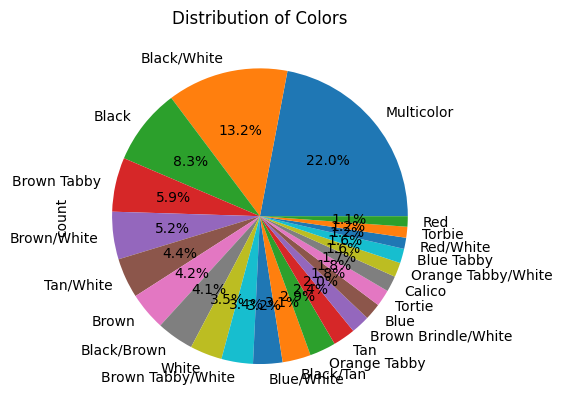

In [134]:
color_counts = data['Color'].value_counts()
color_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Colors')
plt.show()

Display of distribution of season and outcome

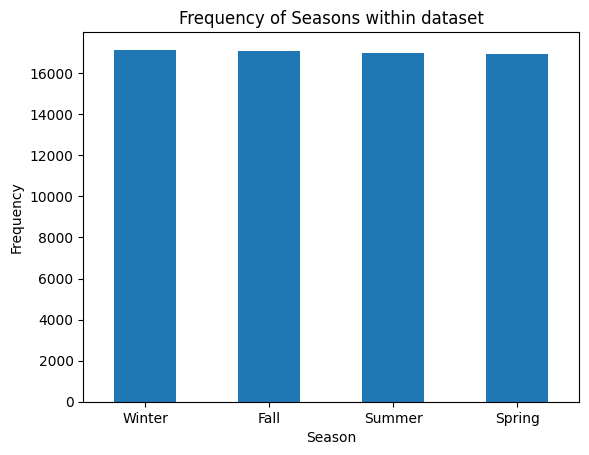

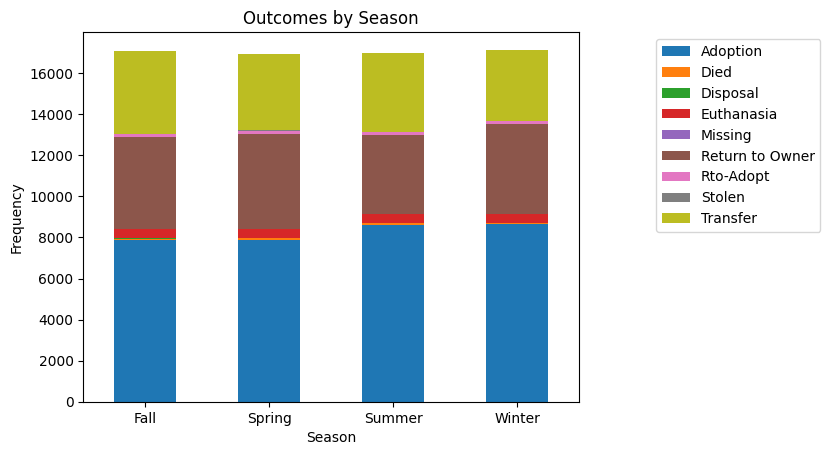

In [135]:
season_counts = dog_data['Season'].value_counts()
season_counts.plot(kind='bar')
plt.title('Frequency of Seasons within dataset')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.show()

outcome_by_season = pd.crosstab(dog_data['Season'], dog_data['Outcome Type'])
outcome_by_season.plot(kind='bar', stacked=True)
plt.title('Outcomes by Season')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

plt.show()


Distribution of dog breed sizes for the top 100 breeds in the dataset.  

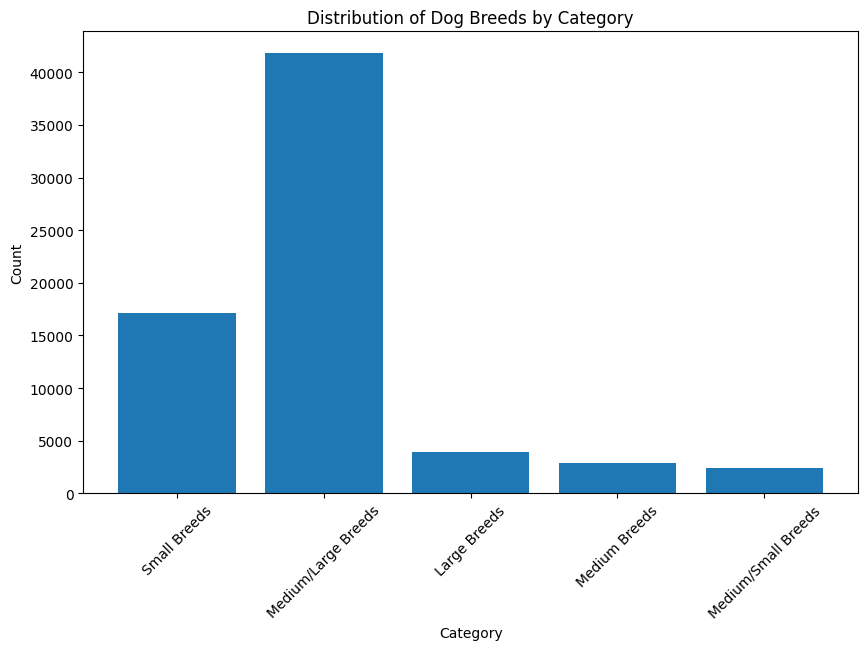

In [136]:
category_labels = [label for label, value in category_counts.items() if label is not None]
category_values = [value for label, value in category_counts.items() if label is not None]


plt.figure(figsize=(10, 6))
plt.bar(category_labels, category_values)
plt.title('Distribution of Dog Breeds by Category')
plt.xlabel('Category')
plt.ylabel('Count')

plt.xticks(rotation=45)

plt.show()

Distribution of dog sex upon Outcome.

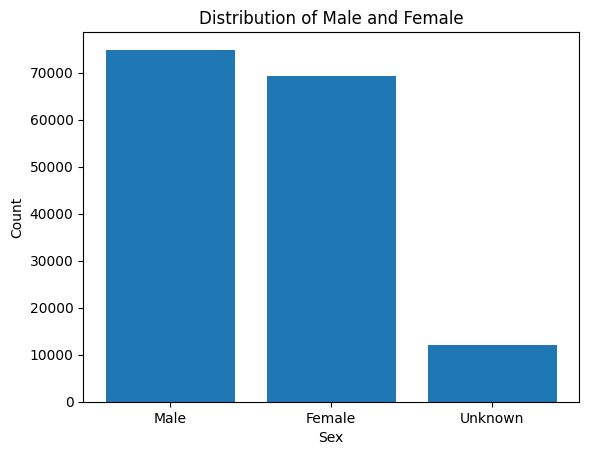

Number of Males: 74906
Number of Females: 69323
Number of Unkown: 12145


In [137]:
sex_upon_outcome = data["Sex upon Outcome"]

male = 0
female = 0
unknown = 0

for outcome in sex_upon_outcome:
    if pd.notna(outcome):
        if "Male" in outcome:
            male += 1
        elif "Female" in outcome:
            female += 1
        elif "Unknown" in outcome or "nan" in outcome: 
            unknown += 1
        
categories = ["Male", "Female", "Unknown"]
counts = [male, female, unknown]

plt.bar(categories, counts)
plt.title("Distribution of Male and Female")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

print(f"Number of Males: {male}")
print(f"Number of Females: {female}")
print(f"Number of Unkown: {unknown}")



Distrubtion of nuetured vs spayed at outcome.

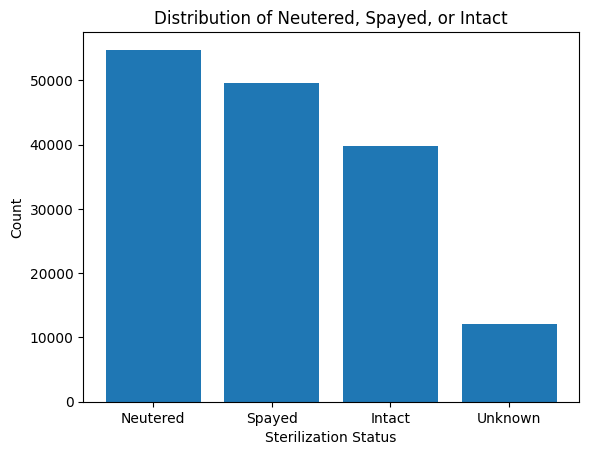

Number of Neutered: 54766
Number of Spayed: 49615
Number of Intact: 39848
Number of Unkown: 12145


In [138]:
neutered = 0
spayed = 0
intact = 0
unkown = 0

color_counts = data['Color'].value_counts()

for outcome in sex_upon_outcome:
    if pd.notna(outcome):
        if "Neutered" in outcome:
            neutered += 1
        elif "Spayed" in outcome:
            spayed += 1
        elif "Intact" in outcome: 
            intact += 1
        elif "Unknown" in outcome or "nan" in outcome: 
            unkown += 1
        
categories = ["Neutered", "Spayed", "Intact", "Unknown"]
counts = [neutered, spayed, intact, unkown]

plt.bar(categories, counts)
plt.title("Distribution of Neutered, Spayed, or Intact")
plt.xlabel("Sterilization Status")
plt.ylabel("Count")
plt.show()

print(f"Number of Neutered: {neutered}")
print(f"Number of Spayed: {spayed}")
print(f"Number of Intact: {intact}")
print(f"Number of Unkown: {unkown}")

Distribution of Months when animals were registered (?)

In [139]:
month_data = data['MonthYear']
df = pd.DataFrame(month_data)
pattern = r'([a-zA-Z]{3}) \d{4}'
df['MonthYear'] = df['MonthYear'].str.extract(pattern)
# print(df)
data.head()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month_counts = df['MonthYear'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, order=month_order)
plt.title('Distribution of Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



NameError: name 'sns' is not defined

<Figure size 1200x600 with 0 Axes>

Convert the age upon outcome into months and then plot the distribution.

Mean Age (in months): 24.18
Median Age (in months): 12.00
Mode Age (in months): 12


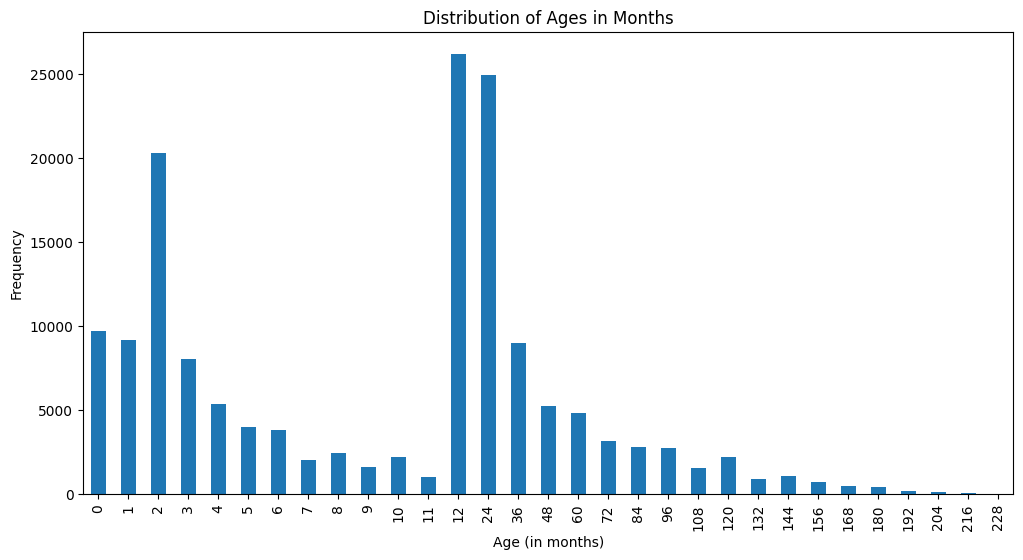

In [140]:
def convert_to_months(age_str):
    # Split the age string into value and unit
    value, unit = age_str.split()
    value = int(value)
    
    if 'year' in unit or 'years' in unit:
        return value * 12
    elif 'month' in unit or 'months' in unit:
        return value
    elif 'week' in unit or 'weeks' in unit:
        return value // 4  # Approximate conversion: 1 month = 4 weeks
    elif 'day' in unit or 'days' in unit:
        return value // 30 # Approximate conversion: 1 month = 30 days
    else:
        return 0  # default case

age_data = data['Age upon Outcome']
df = pd.DataFrame(age_data)
df['Age upon Outcome'] = df['Age upon Outcome'].fillna('0 days')  #  fills NaN with '0 days'
# Apply the conversion function to the column
df['Age upon Outcome'] = df['Age upon Outcome'].apply(convert_to_months)
# print(df.head())

mean_age = df['Age upon Outcome'].mean()
median_age = df['Age upon Outcome'].median()
mode_age = df['Age upon Outcome'].mode()

print(f"Mean Age (in months): {mean_age:.2f}")
print(f"Median Age (in months): {median_age:.2f}")
print(f"Mode Age (in months): {mode_age.iloc[0]}")  

age_counts = df.loc[(df['Age upon Outcome'] >= 0) & (df['Age upon Outcome'] <= 228), 'Age upon Outcome'].value_counts().sort_index()
age_counts.plot(kind='bar', figsize=(12,6))
plt.title('Distribution of Ages in Months')
plt.xlabel('Age (in months)')
plt.ylabel('Frequency')
plt.show()





### Data Modeling
We decided to only use dogs for this dataset because having cat and other would complicate results and cause
our data to fall victim to the curse of dimensionality. 

First we will use Naive Bayes on the Model. 
For this we will create a new dataframe with only dogs. We will limit the dataset to have sex upon outcome, 
breed, color, season, and age. 

### Model 1. Naive Bayes

In [141]:
#only use these columns from the dataset
col_names = ['Sex upon Outcome', 'Breed', 'Color', 'Season']
NB_df = dog_data.loc[:, col_names]
#append age from df and then append outcome type last
NB_df = pd.concat([NB_df, df.iloc[:, 0]], axis=1)
NB_df = pd.concat([NB_df, dog_data[['Outcome Type']]], axis=1)

#set label col to Outcome Type
label = NB_df['Outcome Type']
label.values.ravel()
features= NB_df.drop(['Outcome Type'],axis=1)


#verify we have correct columns
NB_df.head()

,Sex upon Outcome,Breed,Color,Season,Age upon Outcome,Outcome Type
1,Neutered Male,Small Breeds,Brown/White,Summer,12,Adoption
5,Spayed Female,Small Breeds,Brown,Fall,84,Adoption
13,Intact Female,Medium/Large Breeds,Blue/White,Summer,24,Return to Owner
14,Intact Female,Small Breeds,Black/White,Fall,24,Transfer
27,Neutered Male,Small Breeds,Multicolor,Summer,108,Adoption


 Next, create a Multinomial Naive Bayes classifier (since it supports categorical target 
variables) and perform a 10-fold cross validation on the classifier. 
Print accuracy.

In [142]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

# verify shape is correct for NB model
print(NB_df.shape)
print(label.shape)

from sklearn.preprocessing import LabelEncoder
features = pd.DataFrame(features)
label = pd.DataFrame(label)
le = LabelEncoder()
features = features.apply(le.fit_transform)
label = label.apply(le.fit_transform)

# handle non-numeric categorical data and scale features
features = pd.get_dummies(features)
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# finally model data and check accuracy
mnb = MultinomialNB()
mnb_CV = cross_val_score(mnb, features, label, cv=10)
print('Accuracy: ', mnb_CV.mean())

(156376, 6)
(156376,)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was pas

Accuracy:  0.5642489893506767


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/uti

### Model 2. Decision Tree

Next, we created a decision tree model. We extracted the important columns (Season, Color, Breed, Sex upon Outcome, and Age). The breed has already been feature engineered to represent the size of each breed. Color has already been feature engineered. The categorical variables are transformed to numeric using one hot encoding. We perform a K-fold of 4 to shuffle the training and testing data. And the average of all 4 folds represent the overall accuracy of the model. For decision tree, the overall accuracy is 58.7%.

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# get the features that are important for the decision tree
col_names = ['Season', 'Color', 'Breed', 'Sex upon Outcome']
DT_df = dog_data.loc[:, col_names]
DT_df = pd.concat([DT_df, df.iloc[:, 0]], axis=1)

# get the columns that need to be transformed from categorical to numeric
columns_to_encode = ['Sex upon Outcome', 'Breed', 'Color', 'Season']
dog_data_encoded = pd.get_dummies(DT_df, columns=columns_to_encode)
dog_data_encoded = pd.concat([dog_data_encoded, dog_data[['Outcome Type']]], axis=1)

dog_data_encoded.dropna(inplace=True)

# seperate features & labels
X = dog_data_encoded.drop('Outcome Type', axis=1)
y = dog_data_encoded['Outcome Type']

# create a decision tree
dt_model = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# perform cross-validation
cv_scores = cross_val_score(dt_model, X, y, cv=cv, scoring='accuracy')

print("Cross-Validation Scores for each trial:", cv_scores)
print("Mean Accuracy of Decision Tree:", np.mean(cv_scores))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=20.
  warnings.warn(


Cross-Validation Scores for each trial: [0.59800469 0.59818022 0.60199589 0.60023481 0.59172292 0.59084238
 0.59700616 0.59054887 0.59935427 0.58614617 0.59319049 0.5978867
 0.59289698 0.593484   0.59583211 0.59142941 0.58526563 0.58350455
 0.58790725 0.58937482]
Mean Accuracy of Decision Tree: 0.5932404167200641
